In [ ]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
sc.settings.verbosity = 3
sc.logging.print_versions()
os.chdir('./../')


%load_ext autoreload
%autoreload 2 

In [ ]:
adata = sc.read('./datasets/GSM_raw.h5ad')
adata.var_names_make_unique()

In [ ]:
adata.obs['drug'] = [i.split('_')[0] for i in adata.obs['top_oligo']]
adata = adata[adata.obs['drug'] != 'NA']
adata.obs['dose'] = [i.split('_')[1] for i in adata.obs['top_oligo']]
adata.obs['dose'] = adata.obs['dose'].apply(pd.to_numeric, args=('coerce',))

In [ ]:
print(adata.obs['drug'].value_counts())
print('')

In [ ]:
adata.obs['vehicle'] = (adata.obs['dose'] == 0.0)

In [ ]:
adata.obs['vehicle'].value_counts()

In [ ]:
adata.obs['vehicle'] = adata.obs['vehicle'].astype('category')

In [ ]:
adata.obs['drug'][adata.obs['vehicle'] == True] = 'Vehicle'

# QC

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.asarray(adata.X[:, np.flatnonzero(mt_gene_mask)].sum(1)).flatten()/adata.obs['n_counts']

In [ ]:
#Data quality summary plots
#plt.rcParams['figure.figsize'] = (10, 10)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=2, color='drug', alpha=0.6)

In [ ]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='drug', size=0.5, log=True, cut=0, rotation=90)
t1 = sc.pl.violin(adata, 'mt_frac', groupby='drug', size=0.5, log=False, cut=0, rotation=90)

In [ ]:
#Thresholding decision: counts
plt.figure()
sns.distplot(adata.obs['n_counts'], kde=False)
plt.figure()
sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=30)
plt.figure()
sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=30)

In [ ]:
#Thresholding decision: genes
plt.figure()
sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.figure()
sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=20)

In [ ]:
plt.figure()
sns.distplot(adata.obs['mt_frac'], kde=False, bins=60)

In [15]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 750)
adata = adata[adata.obs.mt_frac<0.1]

Total number of cells: 23733
Number of cells after min count filter: 23733
filtered out 434 cells that have less than 750 genes expressed


In [16]:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=100)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58347
filtered out 40656 genes that are detected in less than 100 cells


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 17691


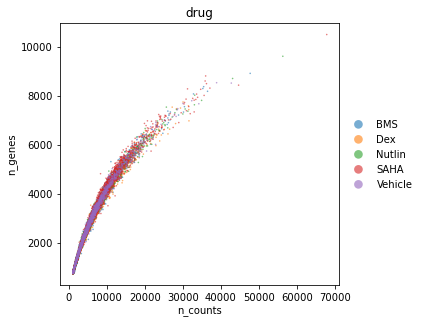

In [17]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='drug', alpha=0.6)

# Normalization

In [18]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [19]:
#Normalize adata 
adata.X /= adata.obs['size_factor'].values[:,None]
sc.pp.log1p(adata)

# HVG

In [20]:
import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4999


# Visualization

In [22]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


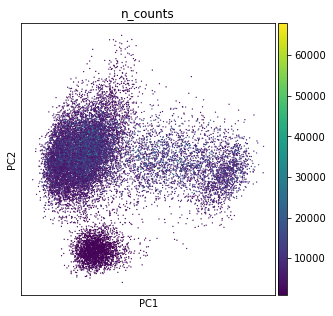

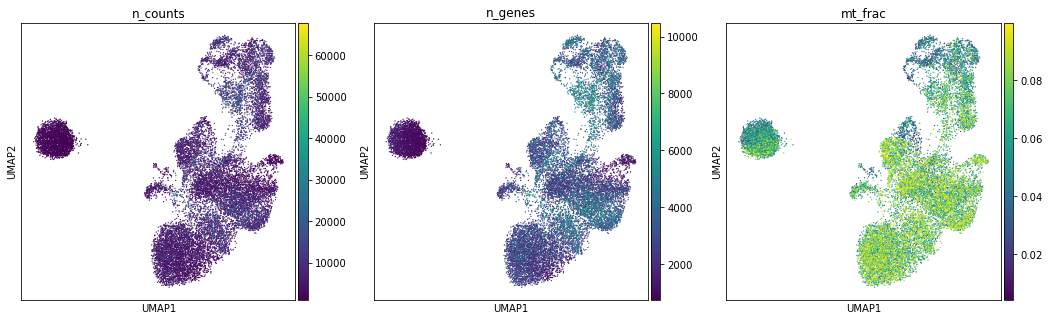

In [23]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color=['n_counts', 'n_genes', 'mt_frac'])

In [24]:
adata.obs['dose'] = adata.obs['dose'].astype(str)
adata.obs['product_dose'] = adata.obs[['drug', 'dose']].apply(lambda x: ' '.join(x), axis=1)

... storing 'dose' as categorical
... storing 'product_dose' as categorical


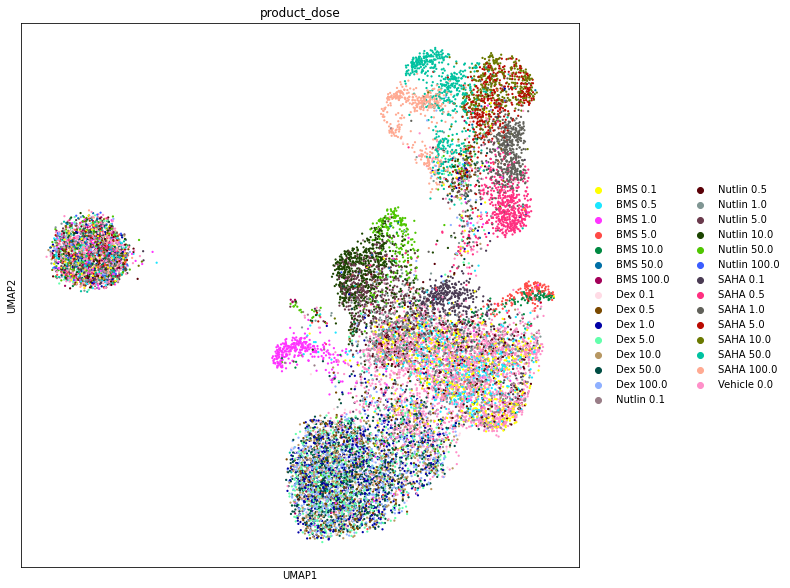

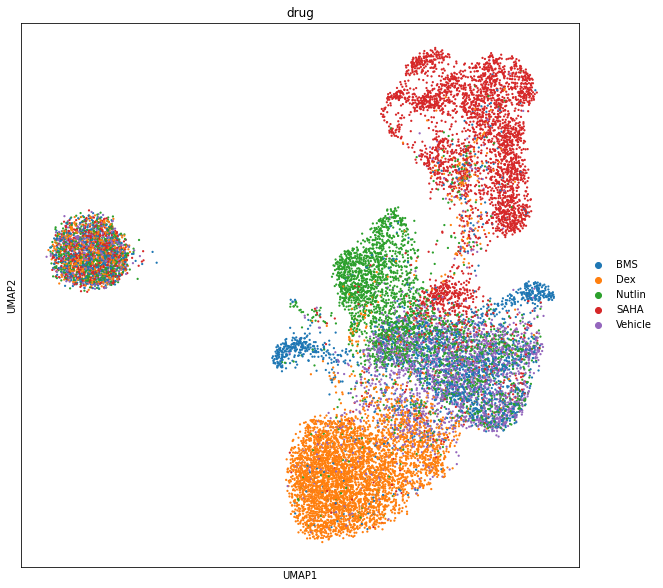

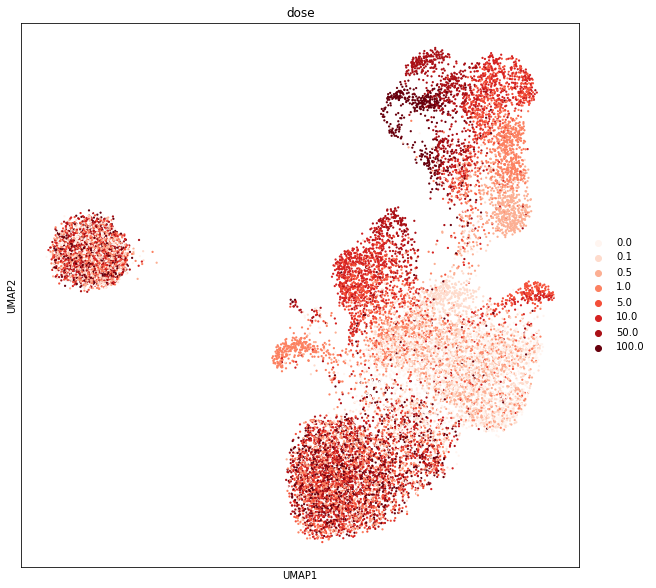

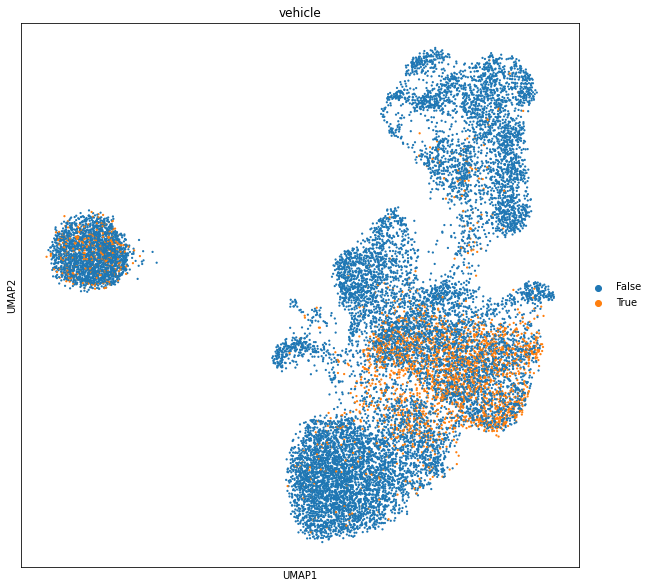

In [25]:
plt.rcParams['figure.figsize'] = (10, 10)
sc.pl.umap(adata, color='product_dose', color_map=sc.pl.palettes.default_20, size=20)
sc.pl.umap(adata, color='drug', color_map=sc.pl.palettes.default_20, size=20)
sc.pl.umap(adata, color='dose', size=20, palette='Reds')
sc.pl.umap(adata, color='vehicle', size=20)

In [26]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


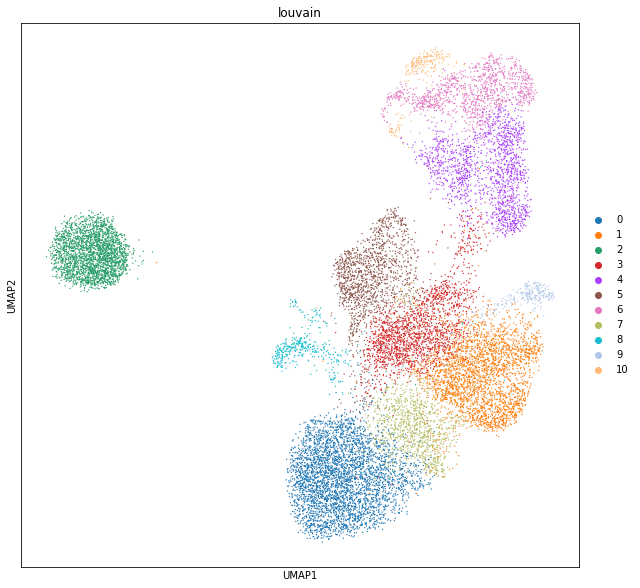

In [27]:
sc.pl.umap(adata, color='louvain')

In [28]:
adata = adata[adata.obs.louvain != '2'] #remove weird cluster

# Prepare for the model

In [32]:
adata.obs['dose_val'] = adata.obs.dose.astype(float) / np.max(adata.obs.dose.astype(float))
adata.obs['dose_val'][adata.obs['drug'].str.contains('Vehicle')] = 1.0

adata.obs['cell_type'] = 'A549'
adata.obs['drug_dose_name'] = adata.obs.drug.astype(str) + '_' + adata.obs.dose_val.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)
adata.obs['condition'] = adata.obs.drug.copy()
adata.obs['control'] = [1 if x == 'Vehicle_1.0' else 0 for x in adata.obs.drug_dose_name.values]

<ipython-input-32-d7dda4ce20c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['dose_val'][adata.obs['drug'].str.contains('Vehicle')] = 1.0


In [41]:
from compert.helper import rank_genes_groups_by_cov

In [42]:
rank_genes_groups_by_cov(adata, groupby='cov_drug_dose_name', covariate='cell_type', control_group='Vehicle_1.0')

A549
ranking genes


/home/icb/carlo.dedonno/anaconda3/envs/cpi/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'drug_dose_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cov_drug_dose_name' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


# Splits

In [51]:
adata.obs['split'] = 'nan'
adata.obs['split'].loc[
    adata.obs['cov_drug_dose_name'].isin([
        'A549_Dex_0.5', 
        'A549_Nutlin_0.5',
        'A549_SAHA_0.5',
        'A549_BMS_0.5'
    ])
] = 'ood'

/home/icb/carlo.dedonno/anaconda3/envs/cpi/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
from sklearn.model_selection import train_test_split

In [53]:
adata_idx = adata.obs_names[adata.obs.split!='ood']

In [54]:
adata_idx_train, adata_idx_test = train_test_split(adata_idx, test_size=0.3, random_state=42)

In [55]:
adata.obs['split'].loc[adata_idx_train] = 'train'
adata.obs['split'].loc[adata_idx_test] = 'test'

In [56]:
adata.obs.groupby('split').size()

split
ood      1767
test     3914
train    9130
dtype: int64

# Cleanup

In [57]:
del adata.raw

In [61]:
adata.write('./datasets/GSM_new.h5ad')

... storing 'cell_type' as categorical
... storing 'drug_dose_name' as categorical
... storing 'cov_drug_dose_name' as categorical
... storing 'split' as categorical
